In [1]:
import os
from tqdm import tqdm
import copy
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

from torchvision.models.efficientnet import EfficientNet

In [2]:
PATH = '/content/drive/MyDrive/mujakjung/cloth/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 확인

In [3]:
train = pd.read_csv(PATH+'train.csv')
train.tail()

,image,sender_id,label,kids
4016,fa5fe172-a5b0-465a-bf25-7e22e7af43cf,232,1,False
4017,6aa750ad-e553-4f9f-bc84-7191530a4fee,282,0,False
4018,2f4e36dd-67e8-47ad-a7d9-1c211fd1b0e3,138,0,False
4019,f309b378-084e-4709-9519-7087175395ca,226,5,False
4020,9c5d41ca-7d77-4a63-becb-72a20224224c,204,1,True


In [4]:
train['image'] = PATH + 'images_compressed/' + train['image'] + '.jpg'

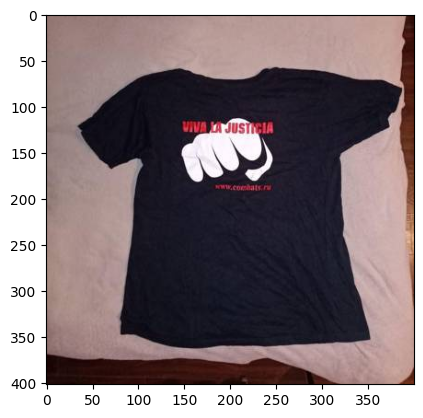

In [5]:
sample = train.iloc[0][0]
img = Image.open(sample)
plt.imshow(img)

# Dataset 정의

In [6]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [7]:
class customdataset():
  def __init__(self, paths, test=False, transform=None):
    self.paths = pd.read_csv(paths)
    self.test = test
    self.train = train
    self.transform = transform

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    x = Image.open(PATH + 'images_compressed/' + self.paths.iloc[idx]['image']+'.jpg')
    y = self.paths.iloc[idx]['label']
    if self.transform: x = self.transform(x)
    if not self.test: return x, y
    else: return x

In [8]:
train_dataset = customdataset(PATH+'train.csv', test=False, transform=transform)
test_dataset = customdataset(PATH+'test.csv', test=True, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 정의

In [ ]:
!pip install efficientnet_pytorch

In [13]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 161MB/s]

Loaded pretrained weights for efficientnet-b0


In [14]:
for parameter in model.parameters():
  parameter.requires_grad = False

num_classes = 16
model._fc = nn.Linear(model._fc.in_features, num_classes)
# model.load_state_dict(torch.load(PATH+'efficientnet_weight.pt'))
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

# 학습

In [15]:
def train_model(model, criterion, optimizer, Epoch):
  model.train()
  train_loss, train_f1 = [], []
  best_f1 = 0
  for epoch in range(1, Epoch+1):
    print(f'Epoch {epoch} / {Epoch}')
    running_loss, num_cnt = 0, 0
    epoch_outputs, epoch_labels = [], []

    for inputs, labels, in tqdm(train_dataloader):
      epoch_labels += labels
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      epoch_outputs += preds.cpu()
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_f1 = f1_score(epoch_outputs, epoch_labels, average='macro')


    print(f'Loss {epoch_loss} F1_score {epoch_f1}')
    train_loss.append(epoch_loss)
    train_f1.append(epoch_f1)

    # best model save
    if best_f1 < epoch_f1:
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH+'efficientnet_weight.pt')
      print(f'Best Model Save {epoch_f1}')

  return model, train_loss, train_f1

In [16]:
Epoch = 15
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [17]:
model, train_loss, train_f1 = train_model(model, criterion, optimizer, Epoch=Epoch)

Epoch 1 / 15


100%|██████████| 126/126 [29:21<00:00, 13.98s/it]


Loss 1.2750008404254913 F1_score 0.4777323509394641
Best Model Save 0.4777323509394641
Epoch 2 / 15


100%|██████████| 126/126 [06:26<00:00,  3.07s/it]


Loss 0.7382931560277939 F1_score 0.6862722707902915
Best Model Save 0.6862722707902915
Epoch 3 / 15


100%|██████████| 126/126 [06:21<00:00,  3.03s/it]


Loss 0.6586544028823338 F1_score 0.7345661828674874
Best Model Save 0.7345661828674874
Epoch 4 / 15


100%|██████████| 126/126 [06:22<00:00,  3.04s/it]


Loss 0.5728827500863681 F1_score 0.7707317078392426
Best Model Save 0.7707317078392426
Epoch 5 / 15


100%|██████████| 126/126 [06:15<00:00,  2.98s/it]


Loss 0.582655009769258 F1_score 0.7668649435127526
Best Model Save 0.7668649435127526
Epoch 6 / 15


100%|██████████| 126/126 [06:23<00:00,  3.04s/it]


Loss 0.5757639945026428 F1_score 0.7810122622475186
Best Model Save 0.7810122622475186
Epoch 7 / 15


100%|██████████| 126/126 [06:28<00:00,  3.08s/it]


Loss 0.5163367082557034 F1_score 0.808337863852732
Best Model Save 0.808337863852732
Epoch 8 / 15


100%|██████████| 126/126 [06:19<00:00,  3.02s/it]


Loss 0.5451365761340611 F1_score 0.7904974347691704
Best Model Save 0.7904974347691704
Epoch 9 / 15


100%|██████████| 126/126 [06:14<00:00,  2.97s/it]


Loss 0.5426551231316158 F1_score 0.7923632013706139
Best Model Save 0.7923632013706139
Epoch 10 / 15


100%|██████████| 126/126 [06:12<00:00,  2.96s/it]


Loss 0.49850531111633967 F1_score 0.8275842744966182
Best Model Save 0.8275842744966182
Epoch 11 / 15


100%|██████████| 126/126 [06:23<00:00,  3.04s/it]


Loss 0.5039421887624831 F1_score 0.8305195044815858
Best Model Save 0.8305195044815858
Epoch 12 / 15


100%|██████████| 126/126 [06:12<00:00,  2.96s/it]


Loss 0.5691479843937688 F1_score 0.810263906259847
Best Model Save 0.810263906259847
Epoch 13 / 15


100%|██████████| 126/126 [06:12<00:00,  2.96s/it]


Loss 0.48831998509547064 F1_score 0.8195861269023934
Best Model Save 0.8195861269023934
Epoch 14 / 15


100%|██████████| 126/126 [06:14<00:00,  2.97s/it]


Loss 0.559503912245707 F1_score 0.8128421095243173
Best Model Save 0.8128421095243173
Epoch 15 / 15


100%|██████████| 126/126 [06:23<00:00,  3.04s/it]


Loss 0.5144696736501323 F1_score 0.8258872240408615
Best Model Save 0.8258872240408615


# 모델 평가

In [28]:
def vaild_model():
  model.eval()
  y_preds = []
  with torch.no_grad():
    for inputs in tqdm(test_dataloader):
      inputs = inputs.to(device)
      preds = model(inputs)
      _, preds = torch.max(preds, 1)
      y_preds += preds
  return y_preds

In [29]:
y_result = pd.read_csv(PATH+'test.csv')['label']
y_preds = vaild_model()
print('Test F1 Score:', f1_score(y_preds, y_result, average='macro'))

100%|██████████| 32/32 [04:19<00:00,  8.10s/it]

Test F1 Score: 0.6163547599027143


In [37]:
# 라벨 dict 생성
image_label = pd.read_csv(PATH+'images.csv')
cols = ['Not sure', 'Body', 'Other', 'Skip']
image_label = image_label.loc[~image_label['label'].isin(cols)]
classes = image_label['label'].unique()
tmp = {}
for idx, c in enumerate(classes):
    tmp[idx] = c
print(tmp)

{0: 'T-Shirt', 1: 'Shoes', 2: 'Shorts', 3: 'Shirt', 4: 'Pants', 5: 'Skirt', 6: 'Top', 7: 'Outwear', 8: 'Dress', 9: 'Longsleeve', 10: 'Undershirt', 11: 'Hat', 12: 'Polo', 13: 'Blouse', 14: 'Hoodie', 15: 'Blazer'}


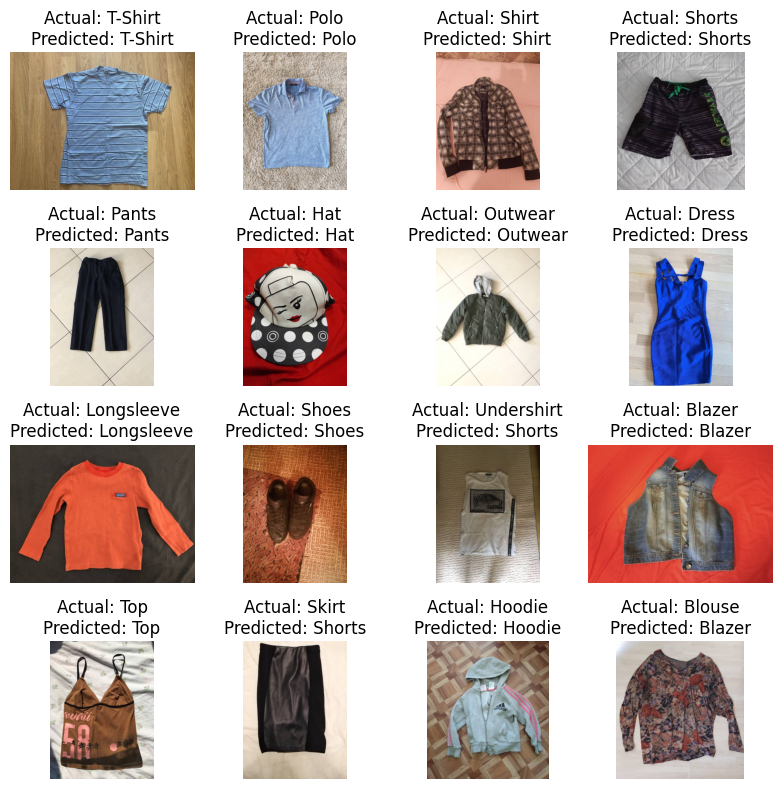

In [43]:
df = pd.read_csv(PATH+'test.csv')


# PyTorch 모델 및 가중치 로드
model.eval()


# 4x4 그리드로 이미지 및 분류 결과 표시
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i, label in enumerate(df['label'].unique()):
    label_df = df[df['label'] == label].sample(1)  # 각 라벨에서 하나의 이미지 선택
    image_path = PATH + 'images_compressed/' + label_df['image'].values[0] + '.jpg'

    # 이미지 열기 및 전처리
    img = Image.open(image_path)
    img = transform(img)
    img = img.unsqueeze(0)  # 배치 차원 추가

    # 모델로 예측 수행
    with torch.no_grad():
        output = model(img)

    _, predicted_class = output.max(1)
    predicted_label = str(predicted_class.item())

    # 이미지 및 분류 결과 그리기
    row = i // 4
    col = i % 4
    axs[row, col].imshow(plt.imread(image_path))
    axs[row, col].set_title(f'Actual: {tmp[int(label)]}\nPredicted: {tmp[int(predicted_label)]}')
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()